In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, regularizers # Import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.applications import ResNet50,MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam # Import Adam optimizer

In [2]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 6s 0us/step


# Data Exploring and Visualization

In [3]:
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (50000, 32, 32, 3)
Train labels shape: (50000, 1)
Test images shape: (10000, 32, 32, 3)
Test labels shape: (10000, 1)


In [4]:
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
print("Number of classes:", len(class_names))

Number of classes: 10


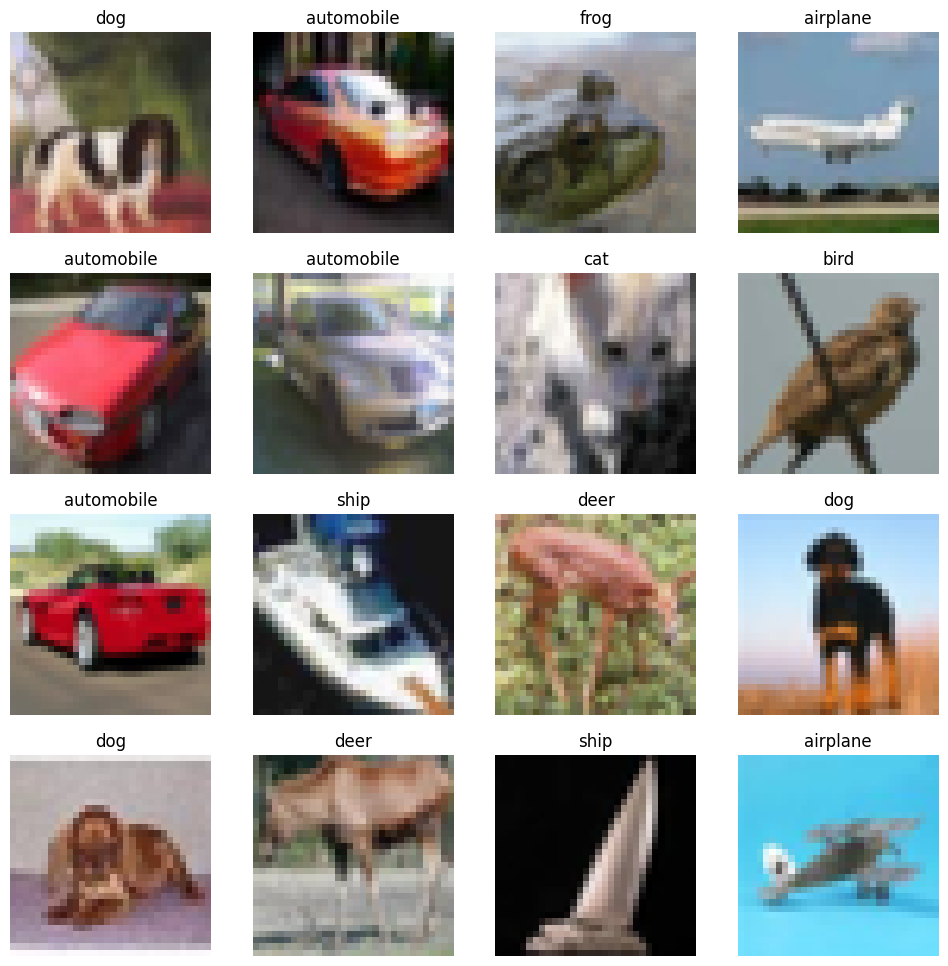

In [5]:
plt.figure(figsize=(12,12))
for i in range(16):
    idx = np.random.randint(0, len(train_images))
    plt.subplot(4,4,i+1)
    plt.imshow(train_images[idx])
    plt.title(class_names[train_labels[idx][0]])
    plt.axis("off")
plt.show()

/tmp/ipython-input-181070764.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x="class_name",


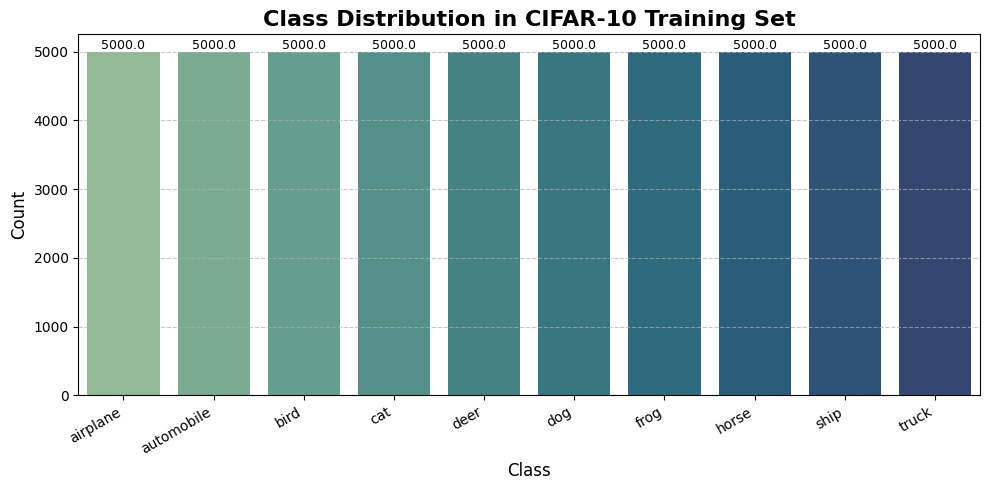

In [6]:
train_labels_df = pd.DataFrame({
    "label": train_labels.flatten()
})
train_labels_df["class_name"] = train_labels_df["label"].apply(lambda x: class_names[x])

plt.figure(figsize=(10,5))
ax = sns.countplot(x="class_name",
                   data=train_labels_df,
                   palette="crest",
                   order=class_names)

for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', fontsize=9, color='black', rotation=0)

plt.title("Class Distribution in CIFAR-10 Training Set", fontsize=16, fontweight="bold")
plt.xlabel("Class", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.xticks(rotation=30, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
print("Image shape:", train_images[0].shape)
print("Pixel range:", train_images.min(), "to", train_images.max())

Image shape: (32, 32, 3)
Pixel range: 0 to 255


# Data Preprocessing and Augmentation

## Normalization

In [8]:
train_images = train_images.astype("float32") / 255.0
test_images  = test_images.astype("float32") / 255.0

print("Pixel range after normalization:", train_images.min(), "to", train_images.max())

Pixel range after normalization: 0.0 to 1.0


## One-Hot Encoding

In [9]:
train_labels_cat = to_categorical(train_labels, num_classes=10)
test_labels_cat  = to_categorical(test_labels, num_classes=10)

print("Label shape before:", train_labels.shape)
print("Label shape after one-hot:", train_labels_cat.shape)

Label shape before: (50000, 1)
Label shape after one-hot: (50000, 10)


## Image Generator

In [10]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)

datagen.fit(train_images)

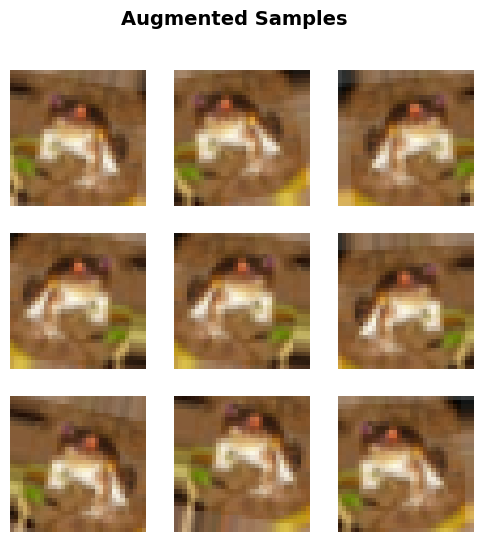

In [11]:
plt.figure(figsize=(6,6))
for i in range(9):
    # Corrected line to get augmented images
    augmented_img = next(datagen.flow(train_images[:1], batch_size=1))
    plt.subplot(3,3,i+1)
    plt.imshow(augmented_img[0])
    plt.axis("off")
plt.suptitle("Augmented Samples", fontsize=14, fontweight="bold")
plt.show()

# Data Modeling

## Build CNN Model

In [12]:
model = models.Sequential([
    layers.Conv2D(32, (3,3), padding="same", kernel_initializer="he_normal",
                  kernel_regularizer=regularizers.l2(1e-3), input_shape=(32,32,3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(32, (3,3), padding="same", kernel_initializer="he_normal",
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.3),

    layers.Conv2D(64, (3,3), padding="same", kernel_initializer="he_normal",
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(64, (3,3), padding="same", kernel_initializer="he_normal",
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.4),

    layers.Conv2D(128, (3,3), padding="same", kernel_initializer="he_normal",
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.Conv2D(128, (3,3), padding="same", kernel_initializer="he_normal",
                  kernel_regularizer=regularizers.l2(1e-3)),
    layers.BatchNormalization(),
    layers.ReLU(),
    layers.MaxPooling2D((2,2)),
    layers.Dropout(0.5),

    layers.Flatten(),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])

# -----------------------
# Compile model
# -----------------------
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 32, 32, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu (ReLU)                    │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 32)     │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_1 (ReLU)                  │ (None, 32, 32, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 16, 16, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16, 16, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 16, 16, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_4 (ReLU)                  │ (None, 8, 8, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_5 (ReLU)                  │ (None, 8, 8, 128)      │             

 Total params: 815,914 (3.11 MB)

 Trainable params: 815,018 (3.11 MB)

 Non-trainable params: 896 (3.50 KB)

In [13]:
# Callbacks
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True
)

checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_cnn_model.keras", save_best_only=True
)

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", factor=0.5, patience=3, verbose=1
)

In [ ]:
history = model.fit(
    datagen.flow(train_images, train_labels_cat, batch_size=64),
    validation_data=(test_images, test_labels_cat),
    epochs=50,
    callbacks=[early_stop, checkpoint, lr_scheduler]
)

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


782/782 ━━━━━━━━━━━━━━━━━━━━ 534s 673ms/step - accuracy: 0.2106 - loss: 3.0154 - val_accuracy: 0.2806 - val_loss: 2.4352 - learning_rate: 0.0010
Epoch 2/50
782/782 ━━━━━━━━━━━━━━━━━━━━ 525s 672ms/step - accuracy: 0.3746 - loss: 2.0775 - val_accuracy: 0.3162 - val_loss: 2.6509 - learning_rate: 0.0010
Epoch 3/50
 30/782 ━━━━━━━━━━━━━━━━━━━━ 7:31 600ms/step - accuracy: 0.4065 - loss: 1.8627

In [ ]:
# Evaluate on test data
test_loss, test_acc = model.evaluate(test_images, test_labels_cat, verbose=2)
print(f"✅ Test Accuracy: {test_acc*100:.2f}%")
print(f"✅ Test Loss: {test_loss:.4f}")

In [ ]:
sns.set_theme(style="whitegrid", palette="muted")

plt.figure(figsize=(14,5))

# Accuracy
plt.subplot(1,2,1)
sns.lineplot(x=range(1, len(history.history['accuracy'])+1), y=history.history['accuracy'], label="Train Accuracy")
sns.lineplot(x=range(1, len(history.history['val_accuracy'])+1), y=history.history['val_accuracy'], label="Val Accuracy")
plt.title("Model Accuracy", fontsize=14, fontweight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.legend()

# Loss
plt.subplot(1,2,2)
sns.lineplot(x=range(1, len(history.history['loss'])+1), y=history.history['loss'], label="Train Loss")
sns.lineplot(x=range(1, len(history.history['val_loss'])+1), y=history.history['val_loss'], label="Val Loss")
plt.title("Model Loss", fontsize=14, fontweight="bold")
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.legend()

plt.tight_layout()
plt.show()